# **Invasive ductal carcinoma (IDC) Breast Cancer Detection**

Submitted:

*   Hadar Pur
*   Rotem Feinblat


In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import math
from glob import glob
import shutil
from pathlib import Path
from os import listdir
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import cv2

### **Preper Kaggle**

In [ ]:
filesBreastCancer = Path("../content/breast-histopathology-images")
filesSkinCancer = Path("../content/skin-cancer-malignant-vs-benign")

if filesBreastCancer.exists() and filesSkinCancer.exists():
  print("Files already loaded")
else:
  # First, let’s install the Kaggle package that will be used for importing the data.
  !pip install kaggle

  # Next, we need to upload the credentials of our Kaggle account. To do so, you need to enter your profile and “Create New API Token”. 
  # If you already have one you can click on “Expire API Token” and create a new one.
  # Then, save the json file with your credentials on your computer and upload this file to Colab using the code below:
  kaggle_file = Path("/content/kaggle.json")
  if kaggle_file.is_file():
    print("kaggle json exist, procceed")
  else:
    from google.colab import files
    files.upload()

  # The Kaggle API client expects the json file to be in ~/.kaggle folder so let’s create a new folder and move it inside.
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json

  # Next, we will click on the three vertical points on the right side of the screen and “Copy the API Command” of the dataset that we want to import from Kaggle.
  # Than we will paste this line of code in our notebook as below:
  !kaggle datasets download -d paultimothymooney/breast-histopathology-images
  !kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign

  # Let’s see the imported files:
  !ls

  # Now, the last step is to open the extracted files and get the data:
  import zipfile
  zip_ref = zipfile.ZipFile('/content/breast-histopathology-images.zip', 'r')
  zip_ref.extractall('/content/breast-histopathology-images')

  zip_ref = zipfile.ZipFile('/content/skin-cancer-malignant-vs-benign.zip', 'r')
  zip_ref.extractall('/content/skin-cancer-malignant-vs-benign')
  
  zip_ref.close()

  print("Done extract data")

Files already loaded


### **Global parameters**

In [ ]:
epochs_idc = 4
epochs_transfer = 2
batch_size = 64
learning_rate_idc = 0.001
learning_rate_transfer = 0.0005

### **Datasets**


In [ ]:
#import kaggle dataset and read data from directory using glob
train_dataset = glob('/content/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive=True)

In [ ]:
# how many data there is (train)
print(len(train_dataset))

277524


In [ ]:
# example of how the data looks like
print(train_dataset[0])

/content/breast-histopathology-images/IDC_regular_ps50_idx5/9291/1/9291_idx5_x2151_y1201_class1.png


In [ ]:
# lets create labels for those images
train_labels = []
for image in train_dataset:
  train_labels.append(int(image[-5]))

print(len(train_labels))

277524


In [ ]:
# create dataframe
dataframe = pd.DataFrame()

dataframe['image'] = train_dataset
dataframe['label'] = train_labels

pd.set_option('display.max_colwidth', None)

display(dataframe)

image  label
0       /content/breast-histopathology-images/IDC_regular_ps50_idx5/9291/1/9291_idx5_x2151_y1201_class1.png      1
1       /content/breast-histopathology-images/IDC_regular_ps50_idx5/9291/1/9291_idx5_x2401_y1551_class1.png      1
2        /content/breast-histopathology-images/IDC_regular_ps50_idx5/9291/1/9291_idx5_x2451_y901_class1.png      1
3       /content/breast-histopathology-images/IDC_regular_ps50_idx5/9291/1/9291_idx5_x2401_y1651_class1.png      1
4       /content/breast-histopathology-images/IDC_regular_ps50_idx5/9291/1/9291_idx5_x2151_y1001_class1.png      1
...                                                                                                     ...    ...
277519   /content/breast-histopathology-images/IDC_regular_ps50_idx5/9259/0/9259_idx5_x1101_y701_class0.png      0
277520   /content/breast-histopathology-images/IDC_regular_ps50_idx5/9259/0/9259_idx5_x2351_y301_class0.png      0
277521    /content/breast-histopathology-images/IDC_regular_ps50_idx5/9259/0/9259_idx5_x851_y551_class0.png      0
277522   /content/breast-histopathology-images/IDC_regular_ps50_idx5/9259/0/9259_idx5_x2801_y851_class0.png      0
277523    /content/breast-histopathology-images/IDC_regular_ps50_idx5/9259/0/9259_idx5_x701_y951_class0.png      0

[277524 rows x 2 columns]

In [ ]:
dataframe.groupby("label")["label"].count()

label
0    198738
1     78786
Name: label, dtype: int64

In [ ]:
# lets split the all data for training and test
train_set, test_set = train_test_split(dataframe, stratify=dataframe.label, test_size=0.2)

In [ ]:
print("train: ", len(train_set))
train_set.groupby("label")["label"].count()

train:  222019


label
0    158990
1     63029
Name: label, dtype: int64

In [ ]:
print("test: ", len(test_set))
test_set.groupby("label")["label"].count()

test:  55505


label
0    39748
1    15757
Name: label, dtype: int64

## **Demo**

In [ ]:
def show_images(dataset):
  fig, ax = plt.subplots(5, 10, figsize=(20,15))

  for n in range(5):
    for m in range(10):
      idx = m + 10*n
      image = cv2.imread(dataset[idx])
      image = cv2.resize(image, (50, 50))
      ax[n,m].imshow(image)
      ax[n,m].grid(False)

### **Malignant demo**

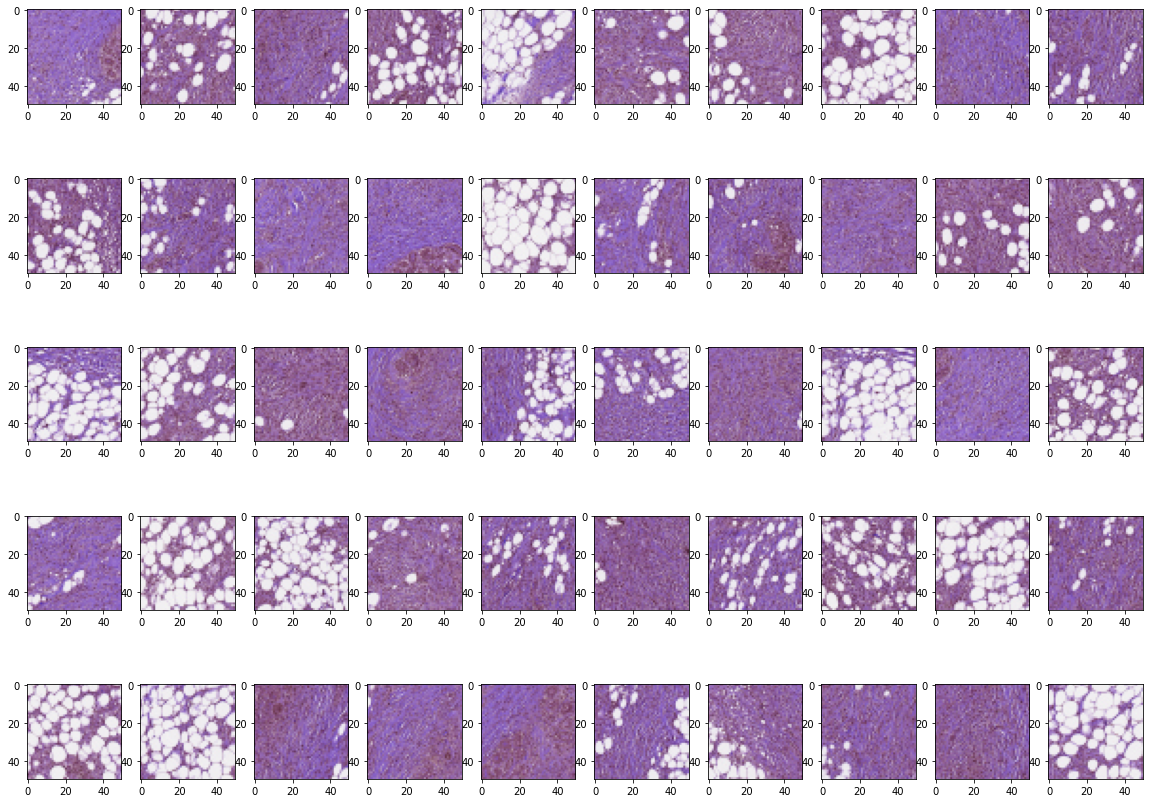

In [ ]:
pattern = 'class1.png'
malignant = list(filter(lambda x: pattern in x, train_dataset))
show_images(malignant)

### **Benign demo**

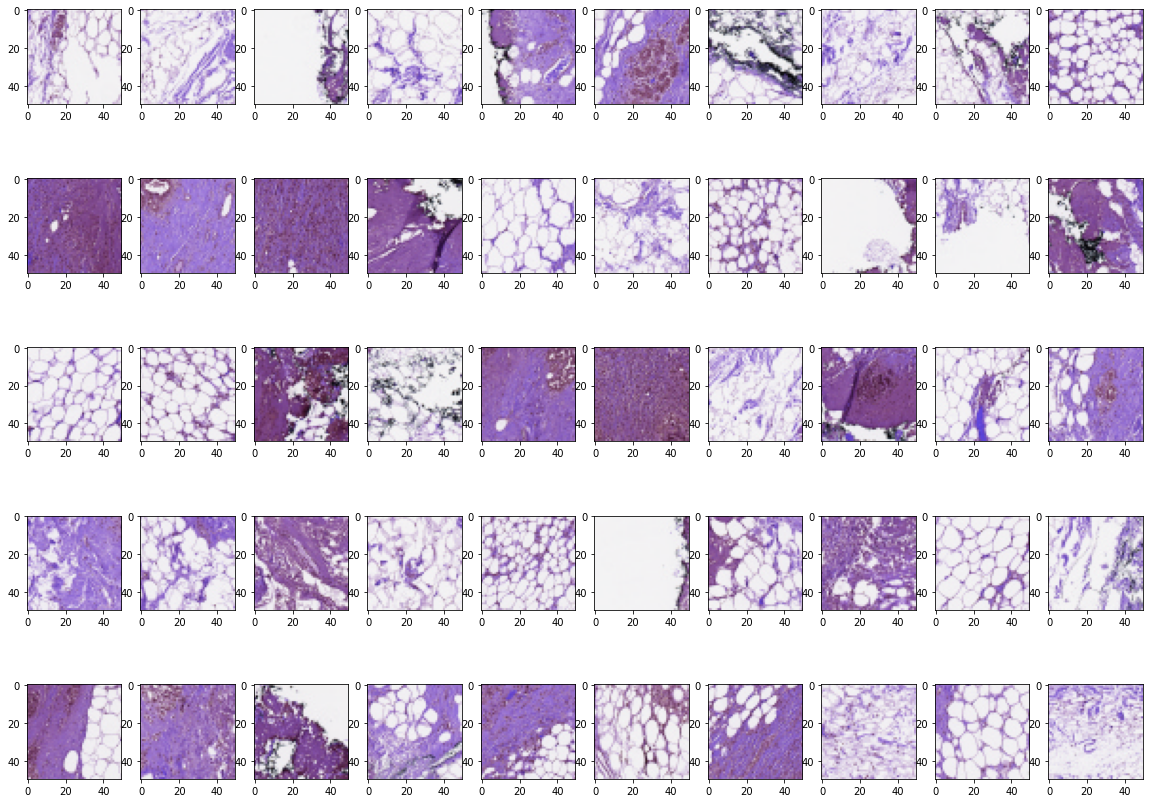

In [ ]:
pattern = 'class0.png'
benign = list(filter(lambda x: pattern in x, train_dataset))
show_images(benign)

## **Dataset class**

In [ ]:
class BreastCancerDataset(torch.utils.data.Dataset):
  def __init__(self, dataframe, trans = None):
    super().__init__()
    self.dataframe = dataframe
    self.trans = trans

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, index):
    image_path, label = self.dataframe[index]
    
    image = cv2.imread(image_path)
    image = cv2.resize(image, (50, 50))
    image = self.trans(image)

    return image, label

In [ ]:
# Train
train_transformation = transforms.Compose([transforms.ToPILImage(), transforms.Pad(64, padding_mode='reflect'), transforms.RandomHorizontalFlip(), 
                                  transforms.RandomVerticalFlip(), transforms.RandomRotation(20), transforms.ToTensor(), transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

train_breastCancer_dataset = BreastCancerDataset(dataframe = train_set.to_numpy(), trans = train_transformation)

train_breastCancer_datasetloader = torch.utils.data.DataLoader(train_breastCancer_dataset, batch_size = batch_size, shuffle = True)

In [ ]:
# Test
test_transformation = transforms.Compose([transforms.ToPILImage(), transforms.Pad(64, padding_mode='reflect'),
                                  transforms.ToTensor(), transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

test_breastCancer_dataset = BreastCancerDataset(dataframe = test_set.to_numpy(), trans = test_transformation)

test_breastCancer_datasetloader = torch.utils.data.DataLoader(test_breastCancer_dataset, batch_size = batch_size, shuffle = False)

## **Training**

In [ ]:
# define loss function
criterion = nn.CrossEntropyLoss()
      
def test(model ,testloader):
  loss_calc = 0.0
  test_loss_array =[] 

  for i, data  in enumerate(testloader, 0):
    # get the inputs
    inputs, labels = data 
      
    inputs = inputs.cuda()  # -- for GPU
    labels = labels.cuda()  # -- for GPU

    outputs = model(inputs)

    loss = criterion(outputs, labels)
    loss_calc += loss.item()
    # if i % batch_size == 0 and i > 1 :    
    #   test_loss_array.append(loss_calc / batch_size)
    #   print('[%d, %5d] test loss: %.3f' % (epoch + 1, i + 1, loss_calc / batch_size))
    #   loss_calc = 0.0
  loss = loss_calc / len(testloader.dataset)
  return loss

# training loop
def train(model, trainloader, testloader):
  # define the optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate_idc)

  # define loss array
  train_loss_array=[]
  test_loss_array=[]

  for epoch in range(epochs_idc):  
    train_loss = 0.0
    test_loss = 0.0
    for i, data in enumerate(trainloader, 0):
      # get the inputs
      inputs, labels = data
      
      inputs = inputs.cuda() # -- For GPU
      labels = labels.cuda() # -- For GPU

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = model(inputs)

      loss = criterion(outputs, labels)

      loss.backward()
      optimizer.step()

      # print statistics
      train_loss += loss.item()     
      # if i % batch_size == 0 and i > 1 : 
      #   # calculate train loss for epoch   
      #   train_loss_array.append(train_loss/batch_size)
      #   print('[%d, %5d] train loss: %.3f' % (epoch + 1, i + 1, train_loss / batch_size))
      #   train_loss = 0.0

    train_loss = train_loss / len(trainloader.dataset)
    train_loss_array.append(train_loss)

    # calculate test loss for epoch
    model.eval()
    test_loss = test(model, testloader)
    test_loss_array.append(test_loss)
    model.train()

    print('epoch [%d] train loss: %.3f' %(epoch + 1, train_loss_array[epoch]))
    print('epoch [%d] test loss: %.3f' %(epoch + 1, test_loss_array[epoch]))

  print('Finished Training')
  return train_loss_array, test_loss_array 

## **Testing**

In [ ]:
def create_plot(array1, array2, label1, label2, x_label, y_label, title):
  
  # plot
  plt.figure(figsize=(10,5)) 
  plt.plot(array1, label = label1, color = "blue")
  plt.plot(array2, label = label2, color = "red")
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)
  plt.legend(loc = 'upper right')
  plt.grid()
  plt.show()

In [ ]:
def calculate_accuracy(model, testloader):
  correct = 0
  total = 0
  with torch.no_grad():
    for data in testloader:
      images, labels = data 
      
      images = images.cuda()  # -- for GPU
      labels = labels.cuda()  # -- for GPU

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

In [ ]:
def calculate_fscore(model, testloader):
  correct = 0
  total = 0
  out = []
  pred=[]
  out2=[]
  pred2=[]
  with torch.no_grad():
    for data in testloader:
      images, labels = data 
          
      images = images.cuda()  # -- for GPU
      labels = labels.cuda()  # -- for GPU

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)

      out.append(labels)
      pred.append(predicted)
  # print("out:",out)
  # print("pred:",predicted)
  for i in range(len(out)):
    for j in range(len(out[i])):
        out2.append(int(out[i][j]))
  for i in range(len(pred)):
    for j in range(len(pred[i])):
        pred2.append(int(pred[i][j]))

  F=f1_score(out2, pred2, average='micro')
  print('F score of the network (pretrained) on the test images: %d %% ' % (F*100))

## **Neural net**

**First try** - 2 layers (linear)

In [ ]:
class BreastCancerCNN_1(nn.Module):
  def __init__(self):
    super(BreastCancerCNN_1, self).__init__()

    # convolution
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 64, 3)
        
    # now a few fully connected layers
    self.fc1 = nn.Linear(64 * 43 * 43, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 10)

  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
    x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

  def num_flat_features(self, x):
    size = x.size()[1:]  # all dimensions except the batch dimension
    num_features = 1
    for s in size:
      num_features *= s
    return num_features

In [ ]:
brestCancerCNNNet_1 = BreastCancerCNN_1().cuda()

print('Start Training for breast cancer cnn net')
train_loss_array_1, test_loss_array_1 = train(brestCancerCNNNet_1, train_breastCancer_datasetloader, test_breastCancer_datasetloader)

Start Training for breast cancer cnn net
epoch [1] train loss: 0.005
epoch [1] test loss: 0.005
epoch [2] train loss: 0.005
epoch [2] test loss: 0.005
epoch [3] train loss: 0.005
epoch [3] test loss: 0.005
epoch [4] train loss: 0.004
epoch [4] test loss: 0.005
Finished Training


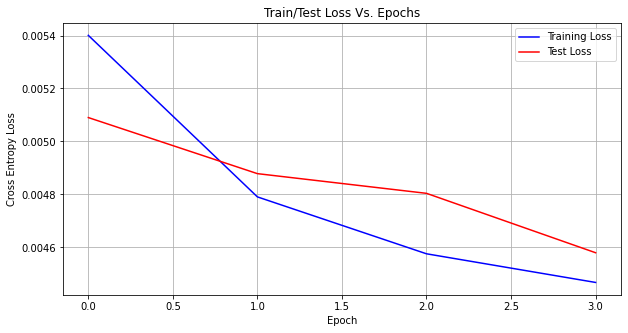

In [ ]:
create_plot(array1 = train_loss_array_1, array2 = test_loss_array_1, label1 = 'Training Loss', label2 = 'Test Loss', x_label = "Epoch", y_label = 'Cross Entropy Loss', title = 'Train/Test Loss Vs. Epochs')

In [ ]:
calculate_accuracy(brestCancerCNNNet_1, test_breastCancer_datasetloader)

Accuracy of the network on the test images: 87 %


In [ ]:
calculate_fscore(brestCancerCNNNet_1, test_breastCancer_datasetloader)

F score of the network (pretrained) on the test images: 87 % 


**Second try** - 3 layers (linear)

In [ ]:
class BreastCancerCNN_2(nn.Module):
  def __init__(self):
    super(BreastCancerCNN_2, self).__init__()

    # convolution
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 64, 3)
    self.conv3 = nn.Conv2d(64, 128, 3)
        
    # now a few fully connected layers
    self.fc1 = nn.Linear(128 * 20 * 20, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 10)

  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
    x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
    x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

  def num_flat_features(self, x):
    size = x.size()[1:]  # all dimensions except the batch dimension
    num_features = 1
    for s in size:
      num_features *= s
    return num_features

In [ ]:
brestCancerCNNNet_2 = BreastCancerCNN_2().cuda()

print('Start Training for breast cancer cnn net')
train_loss_array_2, test_loss_array_2 = train(brestCancerCNNNet_2, train_breastCancer_datasetloader, test_breastCancer_datasetloader)

Start Training for breast cancer cnn net
epoch [1] train loss: 0.005
epoch [1] test loss: 0.005
epoch [2] train loss: 0.005
epoch [2] test loss: 0.004
epoch [3] train loss: 0.004
epoch [3] test loss: 0.004
epoch [4] train loss: 0.004
epoch [4] test loss: 0.005
Finished Training


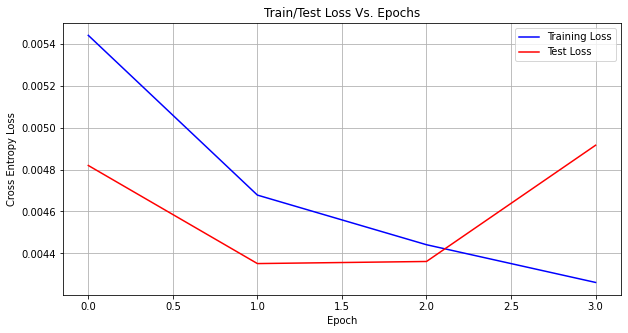

In [ ]:
create_plot(array1 = train_loss_array_2, array2 = test_loss_array_2, label1 = 'Training Loss', label2 = 'Test Loss', x_label = "Epoch", y_label = 'Cross Entropy Loss', title = 'Train/Test Loss Vs. Epochs')

In [ ]:
calculate_accuracy(brestCancerCNNNet_2, test_breastCancer_datasetloader)

Accuracy of the network on the test images: 87 %


In [ ]:
calculate_fscore(brestCancerCNNNet_2, test_breastCancer_datasetloader)

F score of the network (pretrained) on the test images: 87 % 


**Third try** - 4 layers (linear)

In [ ]:
class BreastCancerCNN_3(nn.Module):
  def __init__(self):
    super(BreastCancerCNN_3, self).__init__()

    # convolution
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 64, 3)
    self.conv3 = nn.Conv2d(64, 128, 3)
    self.conv4 = nn.Conv2d(128, 256, 3)
        
    # now a few fully connected layers
    self.fc1 = nn.Linear(256 * 9 * 9, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 128)
    self.fc4 = nn.Linear(128, 64)
    self.fc5 = nn.Linear(64, 10)

  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
    x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
    x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
    x = F.max_pool2d(F.relu(self.conv4(x)), (2, 2))
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = self.fc5(x)
    return x

  def num_flat_features(self, x):
    size = x.size()[1:]  # all dimensions except the batch dimension
    num_features = 1
    for s in size:
      num_features *= s
    return num_features

In [ ]:
brestCancerCNNNet_3 = BreastCancerCNN_3().cuda()

print('Start Training for breast cancer cnn net')
train_loss_array_3, test_loss_array_3 = train(brestCancerCNNNet_3, train_breastCancer_datasetloader, test_breastCancer_datasetloader)

Start Training for breast cancer cnn net
epoch [1] train loss: 0.006
epoch [1] test loss: 0.005
epoch [2] train loss: 0.005
epoch [2] test loss: 0.005
epoch [3] train loss: 0.005
epoch [3] test loss: 0.004
epoch [4] train loss: 0.004
epoch [4] test loss: 0.004
Finished Training


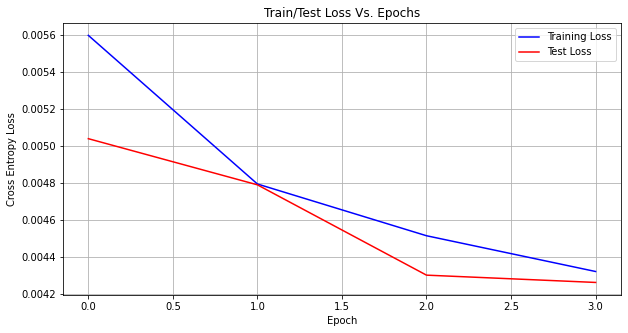

In [ ]:
create_plot(array1 = train_loss_array_3, array2 = test_loss_array_3, label1 = 'Training Loss', label2 = 'Test Loss', x_label = "Epoch", y_label = 'Cross Entropy Loss', title = 'Train/Test Loss Vs. Epochs')

In [ ]:
calculate_accuracy(brestCancerCNNNet_3, test_breastCancer_datasetloader)

Accuracy of the network on the test images: 88 %


In [ ]:
calculate_fscore(brestCancerCNNNet_3, test_breastCancer_datasetloader)

F score of the network (pretrained) on the test images: 88 % 


## **Transfer Learning to Skin Cancer**

### **Dataset**

In [ ]:
#import kaggle dataset and read data from directory using glob
transfer_dataset = glob('/content/skin-cancer-malignant-vs-benign/data/test/**/*.jpg', recursive=True)

In [ ]:
# how many data there is (transfer)
print(len(transfer_dataset))

660


In [ ]:
# example of how the data looks like
print(transfer_dataset[0])

/content/skin-cancer-malignant-vs-benign/data/test/benign/1748.jpg


In [ ]:
# lets create labels for those images
tranfer_labels = []
for image in transfer_dataset:
  if "/benign/" in image:
    tranfer_labels.append(0)
  elif "/malignant/" in image:
    tranfer_labels.append(1)

print(len(tranfer_labels))

660


In [ ]:
# create dataframe
transfer_dataframe = pd.DataFrame()

transfer_dataframe['image'] = transfer_dataset
transfer_dataframe['label'] = tranfer_labels

pd.set_option('display.max_colwidth', None)

display(transfer_dataframe)

image  label
0       /content/skin-cancer-malignant-vs-benign/data/test/benign/1748.jpg      0
1       /content/skin-cancer-malignant-vs-benign/data/test/benign/1768.jpg      0
2       /content/skin-cancer-malignant-vs-benign/data/test/benign/1632.jpg      0
3       /content/skin-cancer-malignant-vs-benign/data/test/benign/1343.jpg      0
4        /content/skin-cancer-malignant-vs-benign/data/test/benign/311.jpg      0
..                                                                     ...    ...
655  /content/skin-cancer-malignant-vs-benign/data/test/malignant/1022.jpg      1
656  /content/skin-cancer-malignant-vs-benign/data/test/malignant/1089.jpg      1
657  /content/skin-cancer-malignant-vs-benign/data/test/malignant/1280.jpg      1
658  /content/skin-cancer-malignant-vs-benign/data/test/malignant/1297.jpg      1
659   /content/skin-cancer-malignant-vs-benign/data/test/malignant/343.jpg      1

[660 rows x 2 columns]

In [ ]:
transfer_dataframe.groupby("label")["label"].count()

label
0    360
1    300
Name: label, dtype: int64

In [ ]:
transfer_train_set, transfer_test_set = train_test_split(transfer_dataframe, stratify=transfer_dataframe.label, test_size=0.2)

In [ ]:
print("train: ", len(transfer_train_set))
transfer_train_set.groupby("label")["label"].count()

train:  528


label
0    288
1    240
Name: label, dtype: int64

In [ ]:
print("test: ", len(transfer_test_set))
transfer_test_set.groupby("label")["label"].count()

test:  132


label
0    72
1    60
Name: label, dtype: int64

### **Malignant demo**

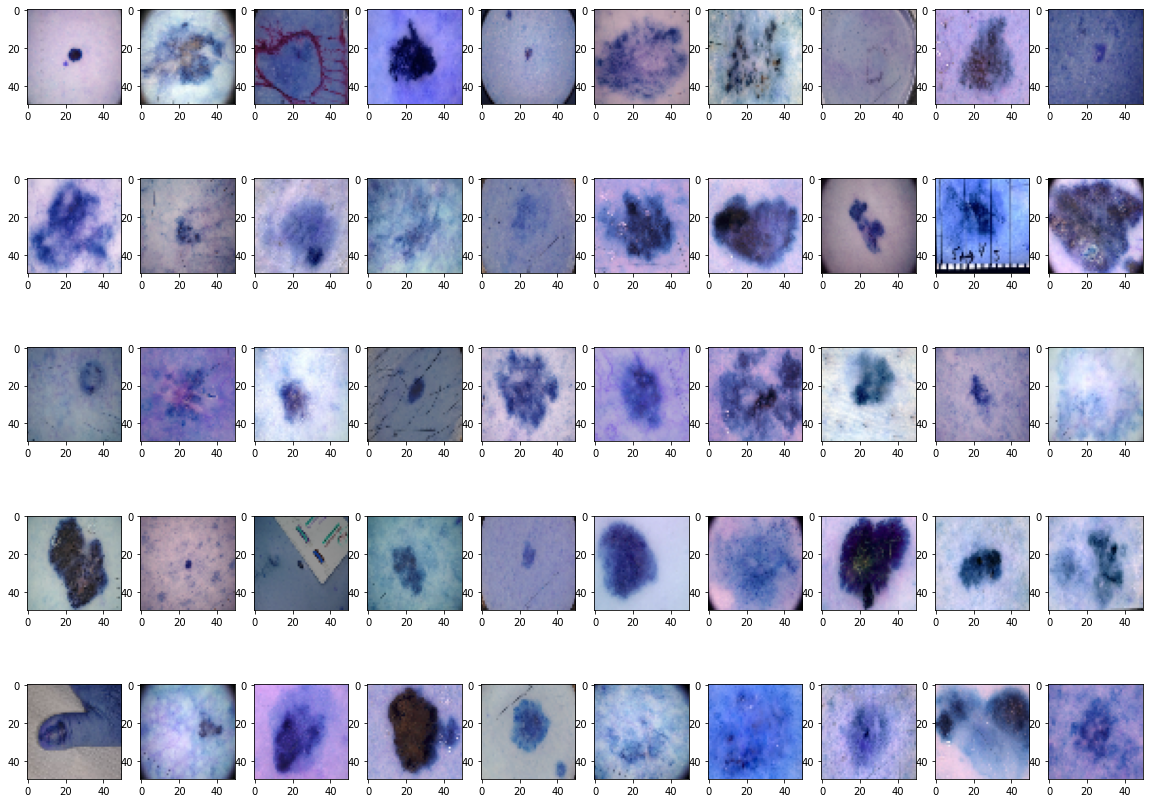

In [ ]:
pattern = '/malignant/'
malignant = list(filter(lambda x: pattern in x, transfer_dataset))
show_images(malignant)

### **Benign demo**

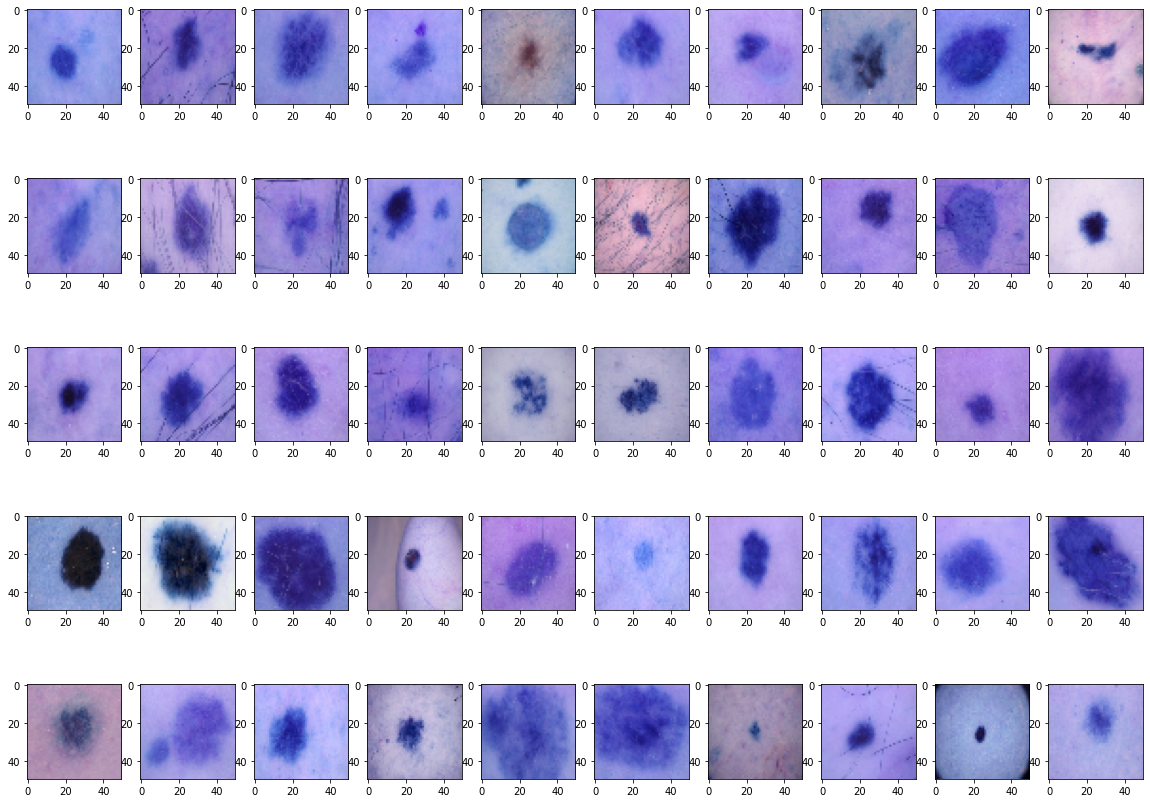

In [ ]:
pattern = '/benign/'
benign = list(filter(lambda x: pattern in x, transfer_dataset))
show_images(benign)

## **Dataset class**

In [ ]:
class SkinCancerDataset(torch.utils.data.Dataset):
  def __init__(self, dataframe, trans = None):
    super().__init__()
    self.dataframe = dataframe
    self.trans = trans

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, index):
    image_path, label = self.dataframe[index]
    
    image = cv2.imread(image_path)
    image = cv2.resize(image, (50, 50))
    image = self.trans(image)

    return image, label

In [ ]:
# transfer
transfer_transformation = transforms.Compose([transforms.ToPILImage(), transforms.Pad(64, padding_mode='reflect'), transforms.RandomHorizontalFlip(), 
                                  transforms.RandomVerticalFlip(), transforms.RandomRotation(20), transforms.ToTensor(), transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

transfer_train_skinCancer_dataset = SkinCancerDataset(dataframe = transfer_train_set.to_numpy(), trans = transfer_transformation)

transfer_train_skinCancer_datasetloader = torch.utils.data.DataLoader(transfer_train_skinCancer_dataset, batch_size = batch_size//4, shuffle = True)

In [ ]:
# Test
test_transfer_transformation = transforms.Compose([transforms.ToPILImage(), transforms.Pad(64, padding_mode='reflect'),
                                  transforms.ToTensor(), transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

test_SkinCancerDataset_dataset = SkinCancerDataset(dataframe = transfer_test_set.to_numpy(), trans = test_transfer_transformation)

test_skinCancerDataset_datasetloader = torch.utils.data.DataLoader(test_SkinCancerDataset_dataset, batch_size = batch_size//4, shuffle = False)

## **Pre/After Training**

In [ ]:
def net_pre_train(trainloader_new, testloader_new, batch):
  pretraind_net = CNN_transfer1().cuda()     # -- For GPU
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(pretraind_net.parameters(), lr=learning_rate_transfer)

  train_loss_array=[]
  test_loss_array=[]

  batch = batch//4
  # training loop
  for epoch in range(epochs_transfer):  
    train_loss = 0.0
    for i, data in enumerate(trainloader_new, 0):
      # get the inputs
      inputs, labels = data # -- For CPU
          
      inputs = inputs.cuda() # -- For GPU
      labels = labels.cuda() # -- For GPU

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = pretraind_net(inputs)

      loss = criterion(outputs[1], labels)
      loss.backward()
      optimizer.step()
        
      train_loss += loss.item()
      # if i % batch == 0 and i > 1 : 
      #   # calculate train loss for epoch   
      #   train_loss_array.append(train_loss/batch)
      #   print('[%d, %5d] train loss: %.3f' % (epoch + 1, i, train_loss / batch))
      #   train_loss = 0.0

    # calculate train loss for epoch
    train_loss_calc = train_loss / len(trainloader_new.dataset)
    train_loss_array.append(train_loss_calc)
      
      
    # calculate test loss for epoch  
    test_loss = 0.0
    for j, data in enumerate(testloader_new, 0):                   
      # get the inputs
      inputs, labels = data
      inputs = inputs.cuda() # -- For GPU
      labels = labels.cuda() # -- For GPU

      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = pretraind_net(inputs)             
      loss = criterion(outputs[1], labels) 

      # print statistics
      test_loss += loss.item()
      # if j % batch == 0 and j > 1 : 
      #   # calculate test loss for epoch   
      #   test_loss_array.append(test_loss/batch)
      #   print('[%d, %5d] test loss: %.3f' % (epoch + 1, j, test_loss / batch))
      #   test_loss = 0.0

    test_loss = test_loss / len(testloader_new.dataset)
    test_loss_array.append(test_loss)

    print('epoch [%d] train loss: %.3f' %(epoch + 1, train_loss_array[epoch]))
    print('epoch [%d] test loss: %.3f' %(epoch + 1, test_loss_array[epoch]))

  print('Finished Training')
        
  return pretraind_net, train_loss_array, test_loss_array

In [ ]:
def after_pre_train(pre_trained_net, trainloader, testloader, batch):
  new_net = CNN_transfer2(pre_trained_net).cuda()      
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(new_net.parameters(), lr=learning_rate_transfer)

  train_loss_array=[]
  test_loss_array=[]

  # training loop
  for epoch in range(epochs_transfer):  
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
      # get the inputs
      inputs, labels = data # -- For CPU
                
      inputs = inputs.cuda() # -- For GPU
      labels = labels.cuda() # -- For GPU
      
      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = new_net(inputs)

      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # print statistics
      train_loss += loss.item()
      # if i % batch == 0 and i > 1 : 
      #   # calculate train loss for epoch   
      #   train_loss_array.append(train_loss/batch)
      #   print('[%d, %5d] train loss: %.3f' % (epoch + 1, i, train_loss / batch))
      #   train_loss = 0.0

    # calculate train loss for epoch
    train_loss_calc = train_loss / len(trainloader.dataset)
    train_loss_array.append(train_loss_calc)
            
            
    # calculate test loss for epoch
    test_loss = 0.0
    for j, data in enumerate(testloader, 0):                 
      # get the inputs
      inputs, labels = data
                    
      inputs = inputs.cuda() # -- For GPU
      labels = labels.cuda() # -- For GPU

      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = new_net(inputs)             
      loss = criterion(outputs, labels) 

      test_loss += loss.item()      
      # if j % batch == 0 and j > 1 : 
      #   # calculate test loss for epoch   
      #   test_loss_array.append(test_loss/batch)
      #   print('[%d, %5d] test loss: %.3f' % (epoch + 1, j, test_loss / batch))
      #   test_loss = 0.0

    test_loss = test_loss / len(testloader.dataset)
    test_loss_array.append(test_loss)

    print('epoch [%d] train loss: %.3f' %(epoch + 1, train_loss_array[epoch]))
    print('epoch [%d] test loss: %.3f' %(epoch+ 1, test_loss_array[epoch]))

  print('Finished Training') 
  return new_net, train_loss_array, test_loss_array 

## **Neural net**

In [ ]:
##define the breast cance net
class CNN_transfer1(nn.Module):
  def __init__(self):
    super(CNN_transfer1, self).__init__()

    # convolution
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 64, 3)
        
    # now a few fully connected layers
    self.fc1 = nn.Linear(64 * 43 * 43, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 10)

  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
    x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    h = F.relu(self.fc2(x))
    out = self.fc3(h)
    return h,out

  def num_flat_features(self, x):
    size = x.size()[1:]  # all dimensions except the batch dimension
    num_features = 1
    for s in size:
      num_features *= s
    return num_features

In [ ]:
class CNN_transfer2(nn.Module):
  def __init__(self, trained_skin_model):
    super(CNN_transfer2, self).__init__()
    self.trained_skin_model = trained_skin_model
    self.fc1 = nn.Linear(64, 32)
    self.fc2 = nn.Linear(32, 16)
    self.fc3 = nn.Linear(16, 10)

  def forward(self, x):
    x,_ = self.trained_skin_model(x)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    out = self.fc3(x)
    return out

### Transfer learning 1

In [ ]:
print('Start pre training for skin cancer cnn net')
pretrain_net, train_loss_array, test_loss_array = net_pre_train(transfer_train_skinCancer_datasetloader, test_skinCancerDataset_datasetloader, batch_size//4)

Start pre training for skin cancer cnn net
epoch [1] train loss: 0.049
epoch [1] test loss: 0.037
epoch [2] train loss: 0.030
epoch [2] test loss: 0.035
Finished Training


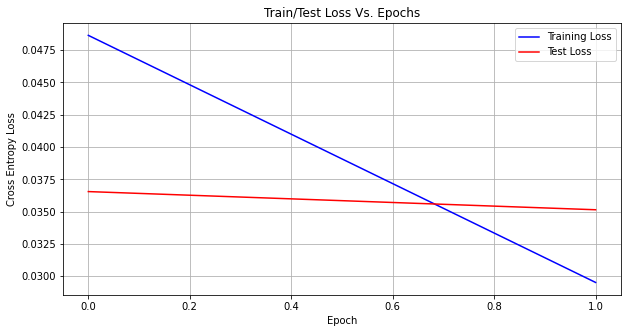

In [ ]:
create_plot(array1 = train_loss_array, array2 = test_loss_array, label1 = 'Training Loss', label2 = 'Test Loss', x_label = "Epoch", y_label = 'Cross Entropy Loss', title = 'Train/Test Loss Vs. Epochs')

In [ ]:
##pre_train_net=pre_train(trainloader_new)
print('Start after pre training for skin cancer cnn net')
new_pretraind_net, train_loss_array2, test_loss_array2 = after_pre_train(pretrain_net, train_breastCancer_datasetloader, test_breastCancer_datasetloader, batch_size)

Start after pre training for skin cancer cnn net
epoch [1] train loss: 0.006
epoch [1] test loss: 0.005
epoch [2] train loss: 0.005
epoch [2] test loss: 0.005
Finished Training


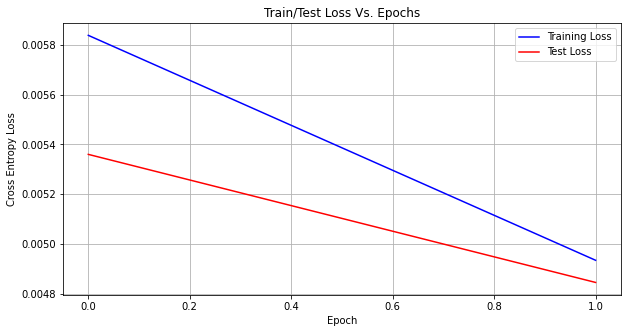

In [ ]:
create_plot(array1 = train_loss_array2, array2 = test_loss_array2, label1 = 'Training Loss', label2 = 'Test Loss', x_label = "Epoch", y_label = 'Cross Entropy Loss', title = 'Train/Test Loss Vs. Epochs')

In [ ]:
calculate_accuracy(new_pretraind_net, test_breastCancer_datasetloader)

Accuracy of the network on the test images: 86 %


In [ ]:
calculate_fscore(new_pretraind_net, test_breastCancer_datasetloader)

F score of the network (pretrained) on the test images: 86 % 


### Transfer learning 2 

In [ ]:
print('Start pre training for skin cancer cnn net')
pretrain_net2, train_loss_array3, test_loss_array3 = net_pre_train(train_breastCancer_datasetloader, test_breastCancer_datasetloader, batch_size)

Start pre training for skin cancer cnn net
epoch [1] train loss: 0.005
epoch [1] test loss: 0.005
epoch [2] train loss: 0.005
epoch [2] test loss: 0.005
Finished Training


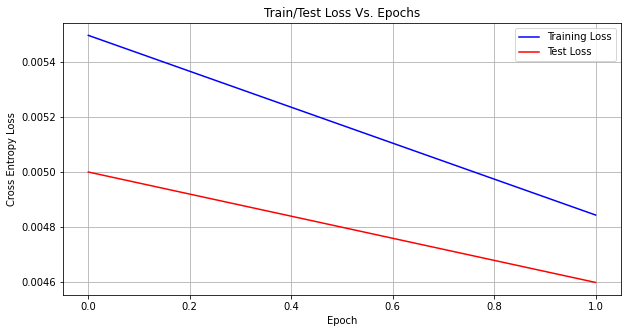

In [ ]:
create_plot(array1 = train_loss_array3, array2 = test_loss_array3, label1 = 'Training Loss', label2 = 'Test Loss', x_label = "Epoch", y_label = 'Cross Entropy Loss', title = 'Train/Test Loss Vs. Epochs')

In [ ]:
print('Start after pre training for skin cancer cnn net')
new_pretraind_net2, train_loss_array4, test_loss_array4 = after_pre_train(pretrain_net, transfer_train_skinCancer_datasetloader, test_skinCancerDataset_datasetloader, batch_size//4)

Start after pre training for skin cancer cnn net
epoch [1] train loss: 0.271
epoch [1] test loss: 0.098
epoch [2] train loss: 0.059
epoch [2] test loss: 0.050
Finished Training


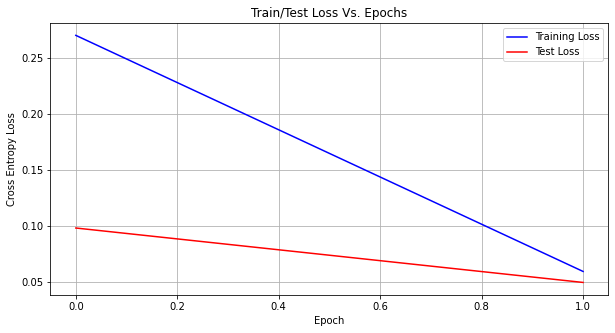

In [ ]:
create_plot(array1 = train_loss_array4, array2 = test_loss_array4, label1 = 'Training Loss', label2 = 'Test Loss', x_label = "Epoch", y_label = 'Cross Entropy Loss', title = 'Train/Test Loss Vs. Epochs')

In [ ]:
calculate_accuracy(new_pretraind_net, test_skinCancerDataset_datasetloader)

Accuracy of the network on the test images: 66 %


In [ ]:
calculate_fscore(new_pretraind_net, test_skinCancerDataset_datasetloader)

F score of the network (pretrained) on the test images: 66 % 
